<a href="https://colab.research.google.com/github/pietrodileo/Python_for_MD_thesis/blob/main/FeatureSelection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Libraries 

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr
from math import sqrt
from sklearn.feature_selection import SelectKBest
import random

%matplotlib inline

In [2]:
#Here's a function for DataFrames (again from SO):

from collections import defaultdict

def reverse_dummy(df_dummies):
    pos = defaultdict(list)
    vals = defaultdict(list)

    for i, c in enumerate(df_dummies.columns):
        if "_" in c:
            k, v = c.split("_", 1)
            pos[k].append(i)
            vals[k].append(v)
        else:
            pos["_"].append(i)

    df = pd.DataFrame({k: pd.Categorical.from_codes(
                              np.argmax(df_dummies.iloc[:, pos[k]].values, axis=1),
                              vals[k])
                      for k in vals})

    df[df_dummies.columns[pos["_"]]] = df_dummies.iloc[:, pos["_"]]
    return df


# Correlation Feature Selection

In [3]:
def getMerit(subset, ClassNumerical):
    k = len(subset)
    # average feature-class correlation
    rcf_all = []
    for feature in subset:
        coeff = pointbiserialr( ClassNumerical, df[feature] )
        rcf_all.append( abs( coeff.correlation ) )
    rcf = np.mean( rcf_all )
    
    # average feature-feature correlation
    corr = df[subset].corr()
    corr.values[np.tril_indices_from(corr.values)] = np.nan
    corr = abs(corr)
    rff = corr.unstack().mean()

    return (k * rcf) / sqrt(k + k * (k-1) * rff)

In [4]:
class PriorityQueue:
    def  __init__(self):
        self.queue = []

    def isEmpty(self):
        return len(self.queue) == 0
    
    def push(self, item, priority):
        """
        item already in priority queue with smaller priority:
        -> update its priority
        item already in priority queue with higher priority:
        -> do nothing
        if item not in priority queue:
        -> push it
        """
        for index, (i, p) in enumerate(self.queue):
            if (set(i) == set(item)):
                if (p >= priority):
                    break
                del self.queue[index]
                self.queue.append( (item, priority) )
                break
        else:
            self.queue.append( (item, priority) )
        
    def pop(self):
        # return item with highest priority and remove it from queue
        max_idx = 0
        for index, (i, p) in enumerate(self.queue):
            if (self.queue[max_idx][1] < p):
                max_idx = index
        (item, priority) = self.queue[max_idx]
        del self.queue[max_idx]
        return (item, priority)

# Load the Dataset from excel (.xlsx file)

In [74]:
# load the dataset
task = 'C2'
excelName = '/content/drive/MyDrive/TesiMagistrale/ExcelForTraining'+'/'+task+'.xlsx'
df = pd.read_excel(excelName)
outpath = '/content/drive/MyDrive/TesiMagistrale/ExcelForTraining/RisultatiFeatureSelection'
# Replace NaN with zero on all columns 
df = df.fillna(0)

# name of the label (can be seen in the dataframe)
label = 'Class'
istance = 'Istance'

# list with feature names (V1, V2, V3, ...)
features = df.columns.tolist()
# keep only numerical values
features.remove(label)
features.remove(istance)

# make a label dataframe
labelVec = df.Class
# create dummy variables
labelDummy = pd.get_dummies(labelVec)
labelDummy.columns = list(range(0, len(labelDummy.columns)))

# reverseDummy: change class labeling to 0 and 1
ClassNumerical = pd.DataFrame(labelDummy.idxmax(axis=1))
ClassNumerical.columns = ['Class']
# convert dataframe to series
ClassNumerical = ClassNumerical.squeeze()

In [6]:
best_value = -1
best_feature = ''
for feature in features:

    coeff = pointbiserialr(ClassNumerical, df[feature] )
    abs_coeff = abs( coeff.correlation )
    if abs_coeff > best_value:
        best_value = abs_coeff
        best_feature = feature

print("Feature %s with merit %.4f"%(best_feature, best_value))

Feature std_8thDelta_delta with merit 0.4563


In [7]:
# initialize queue
queue = PriorityQueue()

# push first tuple (subset, merit)
queue.push([best_feature], best_value)

In [8]:
# list for visited nodes
visited = []

# counter for backtracks
n_backtrack = 0

# limit of backtracks
max_backtrack = 5

In [9]:
# repeat until queue is empty
# or the maximum number of backtracks is reached
while not queue.isEmpty():
    # get element of queue with highest merit
    subset, priority = queue.pop()
    
    # check whether the priority of this subset
    # is higher than the current best subset
    if (priority < best_value):
        n_backtrack += 1
    else:
        best_value = priority
        best_subset = subset

    # goal condition
    if (n_backtrack == max_backtrack):
        break
    
    # iterate through all features and look of one can
    # increase the merit
    for feature in features:
        temp_subset = subset + [feature]
        
        # check if this subset has already been evaluated
        for node in visited:
            if (set(node) == set(temp_subset)):
                break
        # if not, ...
        else:
            # ... mark it as visited
            visited.append( temp_subset )
            # ... compute merit
            merit = getMerit(temp_subset, ClassNumerical)
            # and push it to the queue
            queue.push(temp_subset, merit)

Show the best subset of features

In [10]:
best_subset

['std_8thDelta_delta',
 'F0__TKEO_perc5',
 'Shimmer__F0_PQ11_classical_Schoentgen',
 'mean_deltaDeltaLogEnergy',
 'ATrP',
 'std_MFCC_1stCoef',
 'mean_MFCC_9thCoef',
 'FTrF',
 'std_11thDelta',
 'VFER__SNR_TKEO',
 'F0__TKEO_perc25',
 'std_MFCC_10thCoef']

Merit of the best subset of features

In [11]:
merit

0.6396546856201377

Select columns to take from original df

In [12]:
list1 = list(df.columns)
list2 = best_subset
list3 = []
for i in range(len(list2)):
     for j in range(len(list1)):
            if list2[i]==list1[j]:
                     list3.append(j)
list3.sort()

In [13]:
CFS_dataframe = df.iloc[:, list3]

importancesCFS = mutual_info_classif(CFS_dataframe, ClassNumerical)

mutual_info = pd.Series(importancesCFS)
mutual_info.index = CFS_dataframe.columns
mutual_info.sort_values(ascending=False, inplace = True)
mutual_info

std_8thDelta_delta                       0.152459
std_11thDelta                            0.106097
ATrP                                     0.094049
std_MFCC_1stCoef                         0.090546
VFER__SNR_TKEO                           0.078441
std_MFCC_10thCoef                        0.074722
mean_deltaDeltaLogEnergy                 0.070783
F0__TKEO_perc5                           0.070650
F0__TKEO_perc25                          0.068192
Shimmer__F0_PQ11_classical_Schoentgen    0.039051
FTrF                                     0.009832
mean_MFCC_9thCoef                        0.000000
dtype: float64

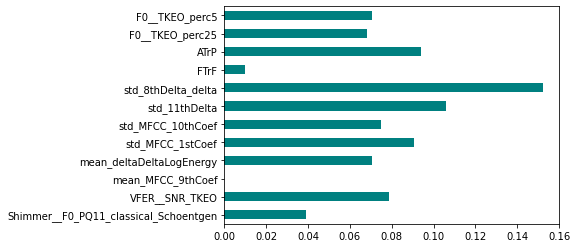

In [14]:
k = 100
bestkfeatures = mutual_info[0:k]

feat_importancesCFS = pd.Series(importancesCFS, CFS_dataframe.columns[0:len(CFS_dataframe.columns)])
feat_importancesCFS.plot(kind='barh',color = 'teal')
plt.show()

Export Data

In [15]:
CFS_dataframe['Class'] = labelVec
CFS_dataframe

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Shimmer__F0_PQ11_classical_Schoentgen,VFER__SNR_TKEO,mean_MFCC_9thCoef,mean_deltaDeltaLogEnergy,std_MFCC_1stCoef,std_MFCC_10thCoef,std_11thDelta,std_8thDelta_delta,FTrF,ATrP,F0__TKEO_perc25,F0__TKEO_perc5,Class
0,0.041030,23.317908,-1.374182,0.000263,1.155641,0.603652,0.036271,0.018273,8.329,7.321,-28.825521,-93.469288,adv_PD-OFF
1,0.201611,174.994553,-1.864712,0.000011,2.336816,0.382592,0.040884,0.023340,4.107,11.895,-71.416031,-202.955946,adv_PD-OFF
2,0.209361,74.719103,-1.185398,0.004429,1.889668,0.371553,0.050021,0.028684,0.000,0.000,-12.225887,-93.910907,adv_PD-OFF
3,0.067874,11.264735,-2.202032,0.000345,1.105404,0.390964,0.046580,0.018909,3.640,6.284,-17.338101,-81.505186,adv_PD-OFF
4,0.193016,7.845078,-0.604674,-0.000004,1.875873,0.393090,0.044827,0.021665,9.988,20.339,-44.348214,-333.201861,adv_PD-OFF
...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,0.065985,4.410814,-0.024912,-0.000558,1.058738,0.310215,0.037917,0.016336,0.000,0.000,-42.548756,-114.791467,Healthy
158,0.095822,4.592292,-2.353136,-0.001129,1.282929,0.305372,0.034833,0.016538,0.000,0.000,-32.560090,-83.018532,Healthy
159,0.146473,4.123211,-0.509009,-0.000656,1.015524,0.318256,0.040167,0.019845,0.000,0.000,-89.493425,-332.463456,Healthy
160,0.187829,8.523173,-1.121840,-0.000180,0.862139,0.344135,0.040111,0.025070,2.984,10.595,-45.144373,-128.738751,Healthy


In [16]:
import os
outname = task+'_CFS_IG.xlsx'
outname2 = task+'_CFS_IG_Rank.xlsx'
outcfs = os.path.join(outpath,outname)
outcfs2 = os.path.join(outpath,outname2)
CFS_dataframe.to_excel(outcfs)
mutual_info.to_excel(outcfs2)

# Information Gain

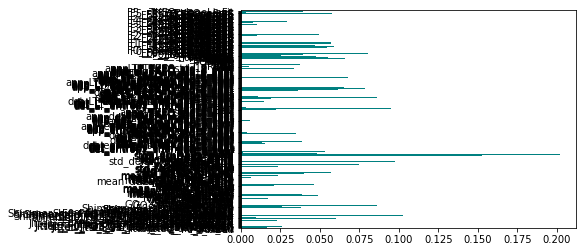

In [17]:
dfIG = df.iloc[: , 1:]
# Drop last column
dfIG.drop(columns=df.columns[-1], 
        axis=1, 
        inplace=True)

importances = mutual_info_classif(dfIG, ClassNumerical)
feat_importances = pd.Series(importances, dfIG.columns[0:len(dfIG.columns)])
feat_importances.plot(kind='barh',color = 'teal')
plt.show()

In [18]:
mutual_info = pd.Series(importances)
mutual_info.index = dfIG.columns
mutual_info.sort_values(ascending=False)

std_10thDelta_delta       0.201702
mean_5thDelta_delta       0.153665
std_8thDelta_delta        0.152459
std_8thDelta              0.142526
mean_6thDelta             0.136265
                            ...   
app_entropy_log_9_coef    0.000000
app_entropy_log_7_coef    0.000000
app_entropy_log_6_coef    0.000000
app_entropy_log_4_coef    0.000000
F5__TKEO_slopeLinFit      0.000000
Length: 455, dtype: float64

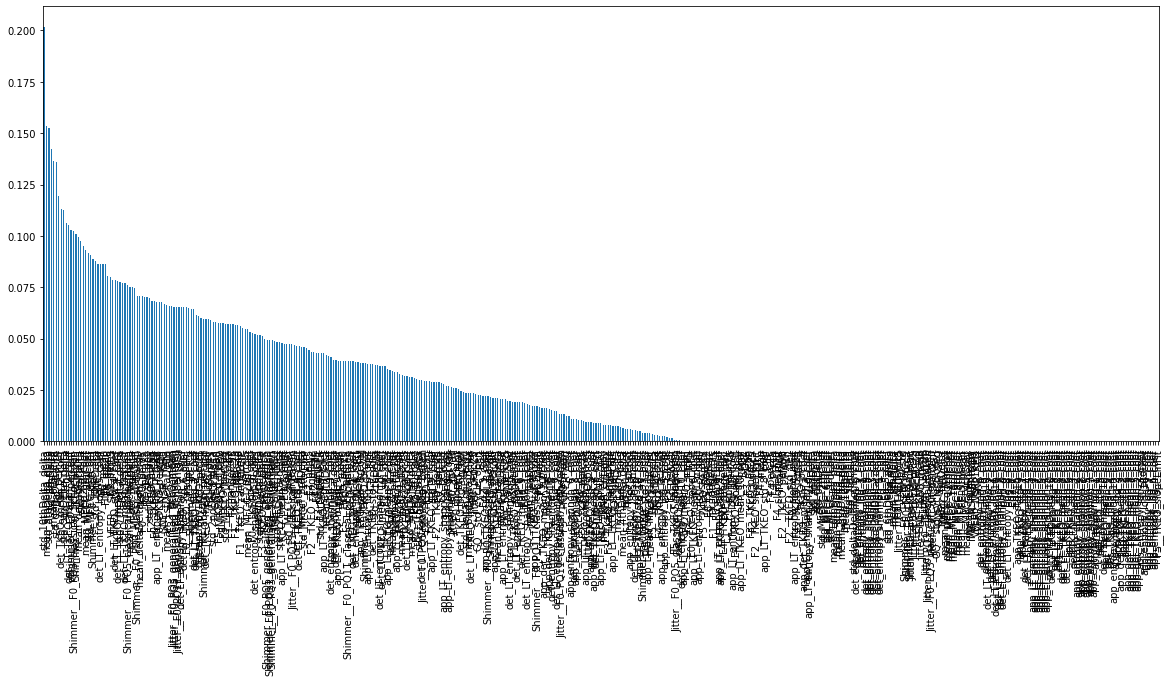

In [19]:
mutual_info.sort_values(ascending=False).plot.bar(figsize=(20, 8))

In [20]:
infogain = pd.DataFrame(mutual_info)
infogain.columns = ['value']
infogain = infogain.sort_values(by=['value'],ascending=False)
infogain = infogain.transpose()

In [21]:
#No we Will select the top k important features
k = 100
IG_k_cols = infogain.iloc[:, :k]
IG_k_cols

,std_10thDelta_delta,mean_5thDelta_delta,std_8thDelta_delta,std_8thDelta,mean_6thDelta,std_deltaDelta0th,F2_perc75,det_TKEO_mean_2_coef,std_9thDelta_delta,std_11thDelta,...,F2__TKEO_perc5,Shimmer__F0_PQ5_generalised_Schoentgen,Shimmer__F0_PQ11_generalised_Schoentgen,Shimmer__F0_PQ3_generalised_Schoentgen,IMF__SNR_TKEO,std_MFCC_4thCoef,std_12thDelta_delta,app_LT_TKEO_mean_7_coef,Ed_8_coef,ACoHNR
value,0.201702,0.153665,0.152459,0.142526,0.136265,0.135946,0.119582,0.113194,0.112809,0.106097,...,0.049556,0.049165,0.049165,0.049165,0.048711,0.048333,0.048269,0.047837,0.047529,0.047418


Export Results

In [22]:
outname = task+'_IG_all.xlsx'
outIG = os.path.join(outpath,outname)
infogain.to_excel(outIG)

# BorutaShap Feature Selection

In [75]:
#!pip install BorutaShap
from BorutaShap import BorutaShap

In [165]:
# load the dataset
task = 'C20'
excelName = '/content/drive/MyDrive/TesiMagistrale/ExcelForTraining'+'/'+task+'.xlsx'
df = pd.read_excel(excelName)
outpath = '/content/drive/MyDrive/TesiMagistrale/ExcelForTraining/RisultatiFeatureSelection'
# Replace NaN with zero on all columns 
df = df.fillna(0)

# name of the label (can be seen in the dataframe)
label = 'Class'
istance = 'Istance'

# list with feature names (V1, V2, V3, ...)
features = df.columns.tolist()
# keep only numerical values
features.remove(label)
features.remove(istance)

# make a label dataframe
labelVec = df.Class
# create dummy variables
labelDummy = pd.get_dummies(labelVec)
labelDummy.columns = list(range(0, len(labelDummy.columns)))

# reverseDummy: change class labeling to 0 and 1
ClassNumerical = pd.DataFrame(labelDummy.idxmax(axis=1))
ClassNumerical.columns = ['Class']
# convert dataframe to series
ClassNumerical = ClassNumerical.squeeze()

In [166]:
dfBS = df.iloc[: , 1:]
# Drop last column
dfBS.drop(columns=df.columns[-1], 
        axis=1, 
        inplace=True)
# If no model is selected default is the Random Forest
# If classification is True it is a classification problem
Feature_Selector = BorutaShap(importance_measure='shap', classification=True)

Feature_Selector.fit(X=dfBS, y=ClassNumerical, n_trials=50, random_state=0)

  0%|          | 0/50 [00:00<?, ?it/s]

18 attributes confirmed important: ['IMF__NSR_TKEO', 'app_LT_TKEO_mean_2_coef', 'Shimmer__F0_PQ3_generalised_Schoentgen', 'GNE__mean', 'mean_deltaDelta0th', 'app_LT_TKEO_mean_3_coef', 'app_LT_TKEO_mean_5_coef', 'app_LT_TKEO_mean_1_coef', 'mean_deltaDeltaLogEnergy', 'std_8thDelta_delta', 'app_entropy_log_1_coef', 'Shimmer__F0_PQ11_generalised_Schoentgen', 'GNE__std', 'std_8thDelta', 'std_MFCC_7thCoef', 'app_LT_TKEO_mean_4_coef', 'std_11thDelta', 'std_10thDelta']
396 attributes confirmed unimportant: ['mean_4thDelta_delta', 'Jitter__F0_PQ5_classical_Baken', 'F4__TKEO_perc95', 'mean_3rdDelta', 'Jitter__F0_PQ11_classical_Baken', 'F0__TKEO_perc95', 'GQ__std_cycle_closed', 'det_TKEO_mean_3_coef', 'Jitter__F0_abs_dif', 'Shimmer__F0_FM', 'RPDE', 'app_LT_TKEO_std_7_coef', 'mean_MFCC_4thCoef', 'det_entropy_log_4_coef', 'det_entropy_log_6_coef', 'det_entropy_log_9_coef', 'F0_Mean', 'mean_9thDelta_delta', 'ATrPS', 'std_MFCC_4thCoef', 'F2__TKEO_rangePerc', 'GNE__SNR_SEO', 'std_6thDelta', 'ATrCIP', 

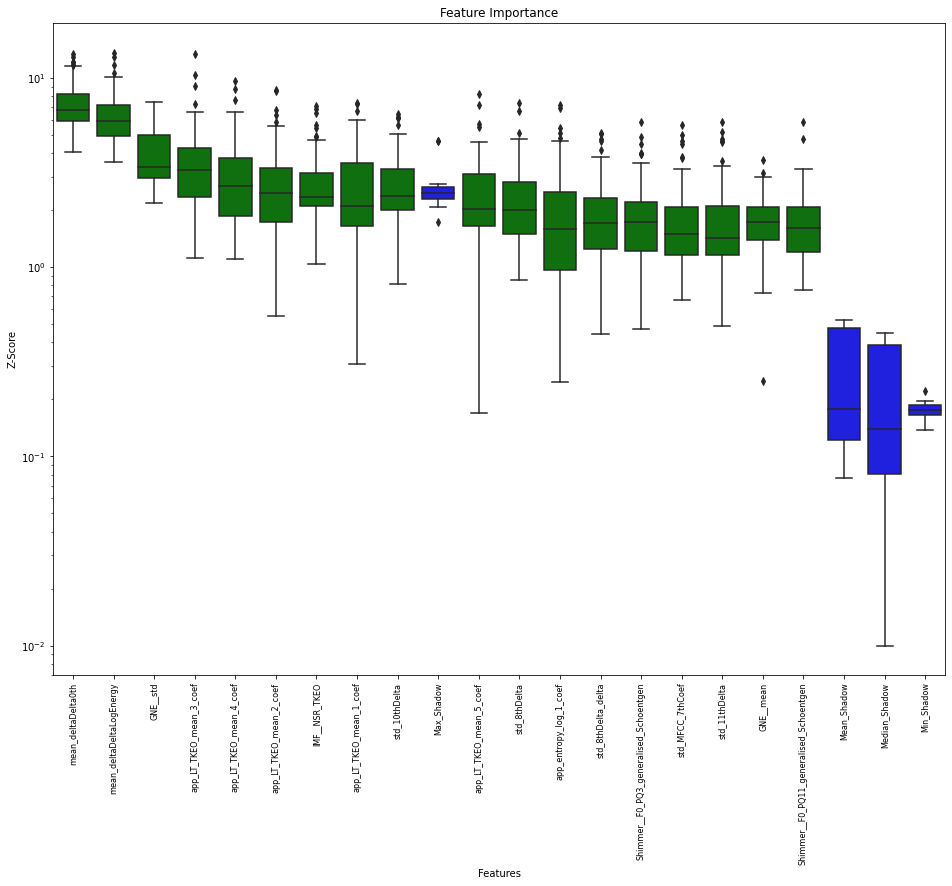

In [167]:
Feature_Selector.plot(which_features='accepted', figsize=(16,12))

In [168]:
# Return a subset of the original data with the selected features
BorShap_dataframe = Feature_Selector.Subset()

In [169]:
BorShap_dataframe['Class'] = labelVec
BorShap_dataframe

,IMF__NSR_TKEO,app_LT_TKEO_mean_2_coef,Shimmer__F0_PQ3_generalised_Schoentgen,GNE__mean,mean_deltaDelta0th,app_LT_TKEO_mean_3_coef,app_LT_TKEO_mean_5_coef,app_LT_TKEO_mean_1_coef,mean_deltaDeltaLogEnergy,std_8thDelta_delta,app_entropy_log_1_coef,Shimmer__F0_PQ11_generalised_Schoentgen,GNE__std,std_8thDelta,std_MFCC_7thCoef,app_LT_TKEO_mean_4_coef,std_11thDelta,std_10thDelta,Class
0,6.445117,2.434464,0.026611,1.021250,0.000335,8.365868,73.870336,0.658812,0.000263,0.018273,1882.654648,0.026611,0.209172,0.038148,0.977383,26.075423,0.036271,0.044958,adv_PD-OFF
1,5.283147,1.715040,0.172329,1.065815,0.000017,6.017451,56.451490,0.462042,0.000011,0.023340,2037.550244,0.172329,0.318426,0.057113,0.417738,19.319217,0.040884,0.050774,adv_PD-OFF
2,14.027043,6.111425,0.180977,0.994720,0.012421,17.027278,92.079540,1.994260,0.004429,0.028684,519.644835,0.180977,0.254251,0.056963,0.470846,41.207395,0.050021,0.052648,adv_PD-OFF
3,10.964933,2.895150,0.053067,1.115865,-0.000547,9.444727,71.784049,0.815971,0.000345,0.018909,1119.332245,0.053067,0.325216,0.045687,0.377700,27.608862,0.046580,0.055770,adv_PD-OFF
4,5.386226,0.441681,0.151196,0.821758,-0.000192,1.696023,22.168273,0.113379,-0.000004,0.021665,7269.183207,0.151196,0.181655,0.042430,0.396144,6.332063,0.044827,0.055257,adv_PD-OFF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,7.429759,1.554878,0.131422,0.769242,-0.001486,5.438630,53.284387,0.432097,-0.000672,0.029348,2286.763181,0.131422,0.163671,0.079002,0.531853,17.979925,0.043735,0.052434,Early_PD
195,7.203889,2.628924,0.087831,0.851140,-0.002523,8.972338,74.954459,0.718707,-0.002103,0.015003,1658.335404,0.087831,0.121152,0.037077,0.237289,27.796528,0.031424,0.036507,Early_PD
196,8.273101,2.867459,0.170480,1.106958,-0.003078,9.516404,74.334893,0.799957,-0.001658,0.022317,1289.982554,0.170480,0.335375,0.050410,0.477923,27.873143,0.071103,0.054411,Early_PD
197,7.654257,2.504252,0.102714,0.706030,-0.001334,8.343911,68.252504,0.690743,-0.000044,0.020003,1410.985746,0.102714,0.104130,0.041429,0.437175,25.029156,0.034821,0.036965,Early_PD


In [170]:
outname = task+'_BorutaShap.xlsx'
outcfs = os.path.join(outpath,outname)
BorShap_dataframe.to_excel(outcfs)
BorShap_dataframe.to_excel(outname)